In [1]:
import os

import numpy as np
import pandas as pd

from pathlib import Path
from tqdm.notebook import tqdm

pd.set_option("display.max_rows", 4000)
pd.set_option("display.max_columns", 100)

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
DATA = '../data'

DEALS = os.path.join(DATA, 'deals.csv')
TRANSACTIONS = os.path.join(DATA, 'trxn.csv')
CLIENTS = os.path.join(DATA, 'client.csv')
MCC_INFO = os.path.join(DATA, 'dict_mcc.csv')
AUM_INFO = os.path.join(DATA, 'aum.csv')
BALANCE_INFO = os.path.join(DATA, 'balance.csv')
CALL_INFO = os.path.join(DATA, 'appl.csv')
TARGET_INFO = os.path.join(DATA, 'funnel.csv')

In [3]:
target = pd.read_csv(TARGET_INFO, sep=',')

In [4]:
target.head()

,client_id,sale_flg,sale_amount,contacts,feature_1,client_segment,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,region_cd
0,7513301859607023584,0,NaN,1,7,13.0,571533.0,15717.0,0.0,0.0,0.0,571852.0,472605.0,10.4,12548.0,86.0
1,9157009756404187626,0,NaN,1,3,13.0,3642369.0,94787.0,0.0,0.0,84823.0,3642369.0,3314257.0,8.9,77210.0,2.0
2,-1893104556496814867,0,NaN,1,5,16.0,352826.0,5500.0,0.0,6822.0,0.0,265893.0,204534.0,8.9,5508.0,52.0
3,6886062013213911831,0,NaN,1,4,3.0,6070615.0,40580.0,0.0,30401.0,0.0,2005731.0,1825051.0,7.9,40583.0,86.0
4,-8156468515495593794,1,138018.05,1,7,14.0,3642369.0,97156.0,81488.0,0.0,160308.0,3642369.0,3314257.0,10.4,78108.0,27.0


## Features

In [5]:
target['feature_5_0'] = target.feature_5 < 1e-10
target['feature_5_1'] = target.feature_5 > 1e-10

In [6]:
target['feature_4_0'] = target.feature_4 < 1e-10
target['feature_4_1'] = target.feature_4 > 1e-10

In [7]:
for col in ['feature_7', 'feature_8', 'feature_9', 'feature_10']:
    target[col] = target[col].fillna(target[col].mode()[0])

In [8]:
client = pd.read_csv(CLIENTS, sep=',')

client.loc[client.education.isna(), 'education'] = 'MISSING'
client.loc[(client.city > 1000) | (client.city == -1), 'city'] = 1001
client.loc[(client.region > 60) | (client.region == -1), 'region'] = 61
client['gender'] = client['gender'].fillna(value='F')
client['age'] = client['age'].fillna(client['age'].mode()[0])

client.head()

,client_id,gender,age,region,city,citizenship,education,job_type
0,7513301859607023584,F,33.0,0,115,RUSSIA,MISSING,NaN
1,9157009756404187626,F,59.0,17,668,RUSSIA,MISSING,NaN
2,-1893104556496814867,M,51.0,28,65,RUSSIA,MISSING,NaN
3,6886062013213911831,F,56.0,0,40,RUSSIA,MISSING,NaN
4,-8156468515495593794,F,34.0,61,1001,RUSSIA,HIGHER_PROFESSIONAL,NaN


In [9]:
client = pd.get_dummies(client, columns=['education', 'job_type', 'citizenship', 'region', 'city', 'gender'])

In [10]:
target = target.set_index('client_id').sort_index()
client = client.set_index('client_id').sort_index()

In [11]:
pd_train = target.join(client)
pd_train.shape

(21498, 844)

In [12]:
pd_trxn_features = pd.read_csv('trxn_features_2.csv', sep=',', index_col='client_id')
pd_trxn_features.shape

(11236, 743)

In [13]:
pd_train['has_trxn_features'] = pd_train.index.isin(set(pd_trxn_features.index))
pd_train = pd_train.join(pd_trxn_features)
pd_train = pd_train.fillna(0)
pd_train.shape

(21498, 1588)

In [14]:
pd_train.head()

,sale_flg,sale_amount,contacts,feature_1,client_segment,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,region_cd,feature_5_0,feature_5_1,feature_4_0,feature_4_1,age,education_FULL_GENERAL,education_HIGHER_PROFESSIONAL,education_HIGHER_PROFESSIONAL_PARTIAL,education_MIDDLE_PROFESSIONAL,education_MISSING,education_PRIMARY_PROFESSIONAL,education_SCHOLASTIC_DEGREE,education_TWO_AND_MORE_HIGHER,job_type_BUSINESS,job_type_MATERNITY_LEAVE,job_type_MILITARY,job_type_RETIRED,job_type_STUDENT,citizenship_RUSSIA,citizenship_UKRAINE,region_0,region_1,region_2,region_3,region_4,region_5,region_6,region_7,region_8,region_9,region_10,region_11,region_12,region_13,region_14,...,mcc_cd_7997_amnt_min,mcc_cd_8021_amnt_min,mcc_cd_7997_amnt_max,mcc_cd_8021_amnt_max,mcc_cd_7997_amnt_std,mcc_cd_8021_amnt_std,mcc_cd_7997_amnt_mean,mcc_cd_8021_amnt_mean,mcc_cd_6300_amnt_sum,mcc_cd_6300_amnt_count,mcc_cd_6300_amnt_min,mcc_cd_6300_amnt_max,mcc_cd_6300_amnt_std,mcc_cd_6300_amnt_mean,mcc_cd_4789_amnt_sum,mcc_cd_7299_amnt_sum,mcc_cd_7922_amnt_sum,mcc_cd_4789_amnt_count,mcc_cd_7299_amnt_count,mcc_cd_7922_amnt_count,mcc_cd_4789_amnt_min,mcc_cd_7299_amnt_min,mcc_cd_7922_amnt_min,mcc_cd_4789_amnt_max,mcc_cd_7299_amnt_max,mcc_cd_7922_amnt_max,mcc_cd_4789_amnt_std,mcc_cd_7299_amnt_std,mcc_cd_7922_amnt_std,mcc_cd_4789_amnt_mean,mcc_cd_7299_amnt_mean,mcc_cd_7922_amnt_mean,mcc_cd_8062_amnt_sum,mcc_cd_8062_amnt_count,mcc_cd_8062_amnt_min,mcc_cd_8062_amnt_max,mcc_cd_8062_amnt_std,mcc_cd_8062_amnt_mean,mcc_cd_5261_amnt_sum,mcc_cd_5261_amnt_count,mcc_cd_5261_amnt_min,mcc_cd_5261_amnt_max,mcc_cd_5261_amnt_std,mcc_cd_5261_amnt_mean,mcc_cd_5714_amnt_sum,mcc_cd_5714_amnt_count,mcc_cd_5714_amnt_min,mcc_cd_5714_amnt_max,mcc_cd_5714_amnt_std,mcc_cd_5714_amnt_mean
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-9221941791080978530,0,0.0,1,9,13.0,1821184.0,79089.0,132280.0,0.0,166263.0,1821184.0,1596130.0,19.4,47644.0,16.0,True,False,False,True,35.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9220369594510368140,0,0.0,1,1,13.0,3642369.0,11288.0,6556.0,0.0,12464.0,508718.0,420428.0,11.9,11290.0,50.0,True,False,False,True,54.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9220236243053692422,1,32920.9,2,1,3.0,3642369.0,24469.0,23073.0,16764.0,49060.0,1141276.0,436482.0,8.9,24474.0,36.0,False,True,False,True,39.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9220233431709087652,0,0.0,1,6,1.0,1371274.0,77447.0,27857.0,61894.0,15563.0,1370745.0,1177470.0,11.9,30422.0,86.0,False,True,False,True,27.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9219699286371310531,0,0.0,1,7,3.0,352826.0,5500.0,0.0,4244.0,0.0,265893.0,204534.0,8.9,5508.0,62.0,False,True,True,False,60.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Train

In [25]:
class KFoldGenerator:
    def __init__(self, path, df):
        locs = {v: k for k, v in enumerate(pd_train.index)}
        
        folds = []
        
        for i in range(5):
            with open(os.path.join(path, f'fold_{i}_train.txt'), mode='r') as inp:
                tr = np.array([*map(int, inp)])
            with open(os.path.join(path, f'fold_{i}_test.txt'), mode='r') as inp:
                te = np.array([*map(int, inp)])
            folds.append((tr, te))

        folds = [
            ([locs[e] for e in fold_train],
             [locs[e] for e in fold_valid], )
            for fold_train, fold_valid in folds
        ]
        
        self.folds = folds
        
    def __iter__(self):
        yield from self.folds
        


kfold = KFoldGenerator(path='../folds/', df=pd_train)

In [16]:
# I'd better use :)

# from sklearn.model_selection import StratifiedKFold

# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=72)

In [17]:
import catboost as cbm

In [18]:
X_train = cbm.Pool(
    data=pd_train.drop(['sale_flg', 'sale_amount', 'contacts', 'region_cd'], axis=1),
    label=pd_train['sale_flg'].to_numpy(),
)

In [19]:
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_fscore_support,
    accuracy_score,
)


params = {
    'objective': 'Logloss',
    'eval_metric': 'AUC',
    'learning_rate': 0.1,
#     'random_state': 42,
    'subsample': 0.7,
    'colsample_bylevel': 0.7,
    'max_depth': 8,
    'num_leaves': 256,
}

In [20]:
%%time

trees = 1000
cv = cbm.cv(pool=X_train, params=params, verbose_eval=True,
            num_boost_round=trees, early_stopping_rounds=50,
            folds=kfold, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8805211	best: 0.8805211 (0)
1:	test: 0.8902559	best: 0.8902559 (1)	total: 4.83s	remaining: 40m 12s
2:	test: 0.9003353	best: 0.9003353 (2)
3:	test: 0.9050551	best: 0.9050551 (3)
4:	test: 0.9094370	best: 0.9094370 (4)
5:	test: 0.9127325	best: 0.9127325 (5)	total: 11s	remaining: 30m 20s
6:	test: 0.9145966	best: 0.9145966 (6)
7:	test: 0.9175136	best: 0.9175136 (7)
8:	test: 0.9194463	best: 0.9194463 (8)
9:	test: 0.9208393	best: 0.9208393 (9)	total: 16.9s	remaining: 27m 55s
10:	test: 0.9221680	best: 0.9221680 (10)
11:	test: 0.9231668	best: 0.9231668 (11)
12:	test: 0.9247603	best: 0.9247603 (12)
13:	test: 0.9259127	best: 0.9259127 (13)	total: 22.6s	remaining: 26m 30s
14:	test: 0.9267804	best: 0.9267804 (14)
15:	test: 0.9279008	best: 0.9279008 (15)
16:	test: 0.9289596	best: 0.9289596 (16)
17:	test: 0.9300476	best: 0.9300476 (17)
18:	test: 0.9307934	best: 0.9307934 (18)	total: 29.2s	remaining: 25m 7s
19:	test: 0.9316735	best: 0.9316735 (19)
20:	test: 0.9324333	best: 0.9324333 (20)
21

In [21]:
cv = pd.DataFrame(cv)

iterations            999.000000
test-AUC-mean           0.991676
test-AUC-std            0.000905
test-Logloss-mean       0.096916
test-Logloss-std        0.002783
train-Logloss-mean      0.058331
train-Logloss-std       0.001253
Name: 999, dtype: float64


999

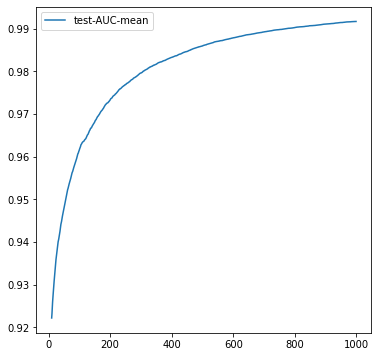

In [22]:
cv[10:].plot(figsize=(6, 6), y=['test-AUC-mean'])
print(cv.loc[cv['test-AUC-mean'].values.argmax()])
trees = cv['test-AUC-mean'].values.argmax()
trees

In [23]:
params['n_estimators'] = trees

In [28]:
%%time

# https://github.com/catboost/catboost/issues/1524

cvbooster = []

for train_index, _ in tqdm(kfold):
    X_train = cbm.Pool(
        data=pd_train.drop(['sale_flg', 'sale_amount', 'contacts', 'region_cd'], axis=1).iloc[train_index],
        label=pd_train['sale_flg'].iloc[train_index],
    )
    
    model = cbm.CatBoostClassifier(**params, thread_count=-1)
    model.fit(X_train, verbose=1)
    
    cvbooster.append(model)

0it [00:00, ?it/s]

0:	total: 68.7ms	remaining: 1m 8s
1:	total: 182ms	remaining: 1m 30s
2:	total: 287ms	remaining: 1m 35s
3:	total: 405ms	remaining: 1m 40s
4:	total: 509ms	remaining: 1m 41s
5:	total: 618ms	remaining: 1m 42s
6:	total: 722ms	remaining: 1m 42s
7:	total: 824ms	remaining: 1m 42s
8:	total: 926ms	remaining: 1m 41s
9:	total: 1.02s	remaining: 1m 41s
10:	total: 1.12s	remaining: 1m 40s
11:	total: 1.21s	remaining: 1m 39s
12:	total: 1.3s	remaining: 1m 38s
13:	total: 1.41s	remaining: 1m 39s
14:	total: 1.5s	remaining: 1m 38s
15:	total: 1.61s	remaining: 1m 38s
16:	total: 1.7s	remaining: 1m 38s
17:	total: 1.79s	remaining: 1m 37s
18:	total: 1.88s	remaining: 1m 37s
19:	total: 1.98s	remaining: 1m 36s
20:	total: 2.07s	remaining: 1m 36s
21:	total: 2.16s	remaining: 1m 35s
22:	total: 2.25s	remaining: 1m 35s
23:	total: 2.35s	remaining: 1m 35s
24:	total: 2.44s	remaining: 1m 35s
25:	total: 2.54s	remaining: 1m 35s
26:	total: 2.64s	remaining: 1m 35s
27:	total: 2.75s	remaining: 1m 35s
28:	total: 2.86s	remaining: 1m 35

In [61]:
feature_importance = []

for booster in cvbooster:
    feature_importance_ = pd.Series(booster.feature_importances_, index=booster.feature_names_)
    feature_importance.append(feature_importance_)
    
feature_importance = pd.concat(feature_importance, axis=1)

feature_importance_mean = feature_importance.mean(axis=1).rename('mean')
feature_importance_std = feature_importance.std(axis=1).rename('std')

indices = feature_importance_mean.argsort()
feature_importance = feature_importance.iloc[indices]
feature_importance_mean = feature_importance_mean[indices]
feature_importance_std = feature_importance_std[indices]

feature_importance_mean[::-1]

education_MISSING                        3.836545e+01
feature_4                                3.455928e+00
feature_9                                2.562456e+00
feature_6                                2.416331e+00
client_segment                           2.090916e+00
age                                      1.843049e+00
feature_1                                1.514870e+00
feature_2                                1.189879e+00
education_MIDDLE_PROFESSIONAL            1.019004e+00
education_HIGHER_PROFESSIONAL            9.330297e-01
num_days_tran_max                        8.872628e-01
num_days_tran_median                     8.376370e-01
feature_8                                7.576562e-01
feature_3                                7.292539e-01
num_days_tran_diff                       7.205741e-01
city_1001                                7.005257e-01
education_PRIMARY_PROFESSIONAL           6.497037e-01
feature_10                               6.438568e-01
num_days_tran_std           

<AxesSubplot:>

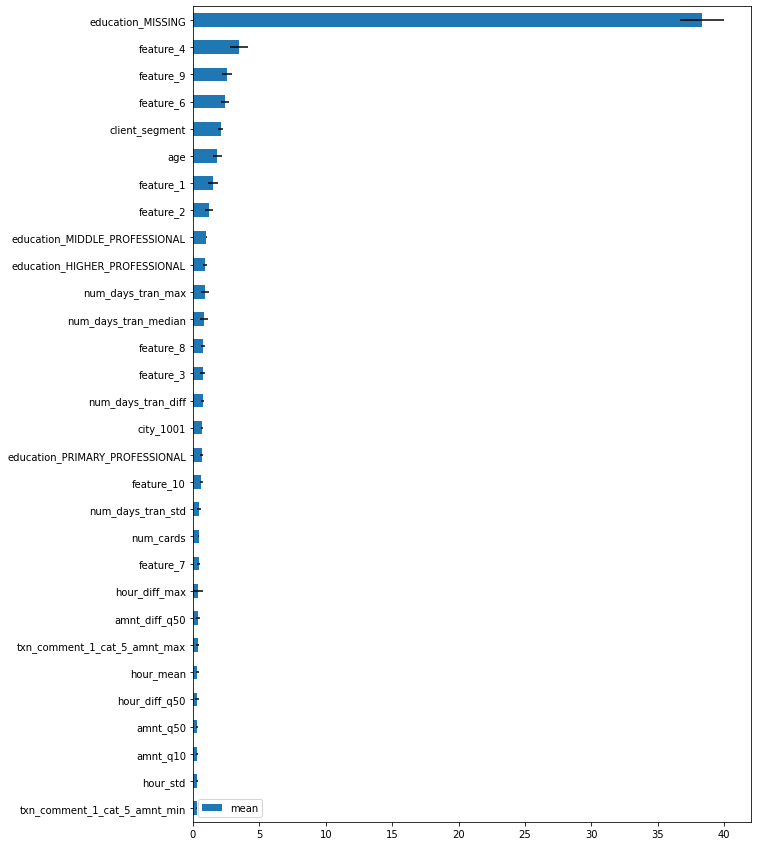

In [62]:
pd.concat([
    feature_importance_mean,
    feature_importance_std,
], axis=1).iloc[-30:].plot.barh(y='mean', figsize=(10, 15), xerr='std')

<AxesSubplot:>

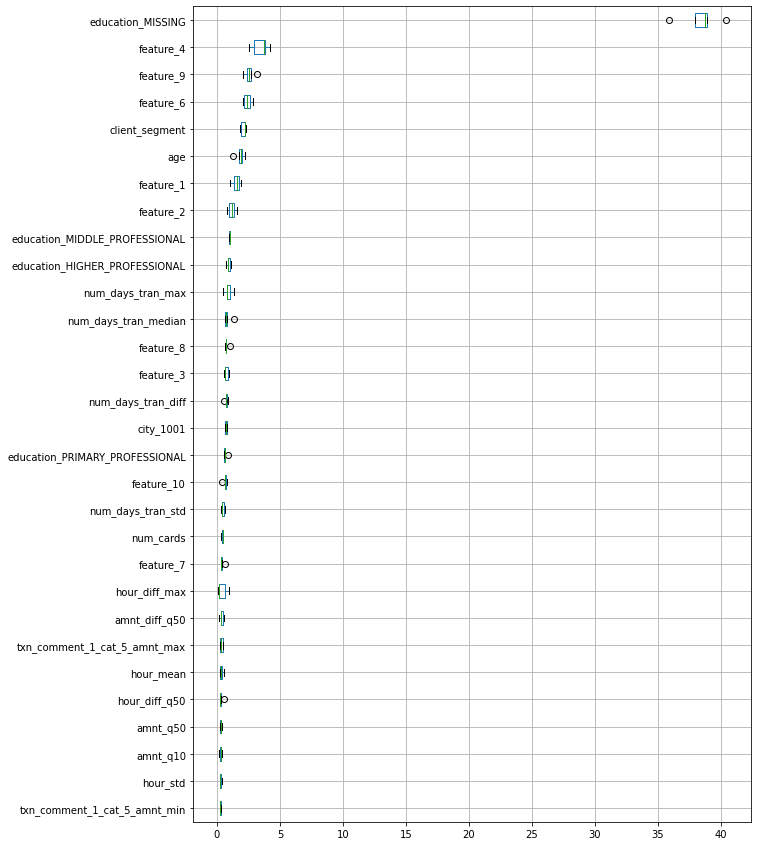

In [63]:
feature_importance.iloc[-30:].T.boxplot(figsize=(10, 15), vert=False)

In [36]:
def eval_metrics(y_true, y_score, earnings, contacts_cnt, thrsh=0.5):
    auc = roc_auc_score(y_true, y_score)
    
    y_pred = y_score > thrsh
    
    acc = accuracy_score(y_true, y_pred)
    pre, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    anic = (y_pred * (earnings - 4000 * contacts_cnt)).mean()
    
    return auc, acc, pre, rec, f1, anic

In [44]:
submission_pull = []

for (_, valid_idx), booster in zip(kfold, tqdm(cvbooster)):
    clients_valid, X_valid, y_valid = (
        pd_train.iloc[valid_idx].index,
        pd_train.loc[:, X_train.get_feature_names()].iloc[valid_idx],
        pd_train.loc[:, 'sale_flg'].iloc[valid_idx],
    )
    
    submission = pd.DataFrame(index=clients_valid)
    submission.index = submission.index.rename('client_id')
    submission['scores'] = booster.predict_proba(X_valid)[:, 1]
    
    submission_pull.append(submission)
    
submission = pd.concat(submission_pull, axis=0)
submission.head()

  0%|          | 0/5 [00:00<?, ?it/s]

,scores
client_id,
-2918739578801888500,0.815268
-4569470415387261653,0.095849
-330127410754871235,0.947311
-8339249258774556753,0.293401
-308621990635499048,0.000179


In [45]:
submission = submission.join(pd_train[['sale_flg', 'sale_amount', 'contacts']])
submission['sale_amount'] = submission['sale_amount'].fillna(0)
submission.head()

,scores,sale_flg,sale_amount,contacts
client_id,,,,
-9217522148893126271,0.823473,1,8278.15,2
-9217522148893126271,0.782294,1,8278.15,2
-9217522148893126271,0.845909,1,8278.15,2
-9217522148893126271,0.430857,1,8278.15,2
-9217522148893126271,0.772385,1,8278.15,2


In [46]:
submission.shape, pd_train.shape

((21495, 4), (21498, 1588))

In [47]:
thresholds = np.linspace(0, 1, 1000)

scores = [
    eval_metrics(submission['sale_flg'], submission['scores'],
                 submission['sale_amount'], submission['contacts'], thrsh)
    for thrsh in tqdm(thresholds, position=0)
]

scores = np.asarray(scores)

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/v.bugaevskii/.conda/envs/idao2021/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/v.bugaevskii/.conda/envs/idao2021/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/v.bugaevskii/.conda/envs/idao2021/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/hom

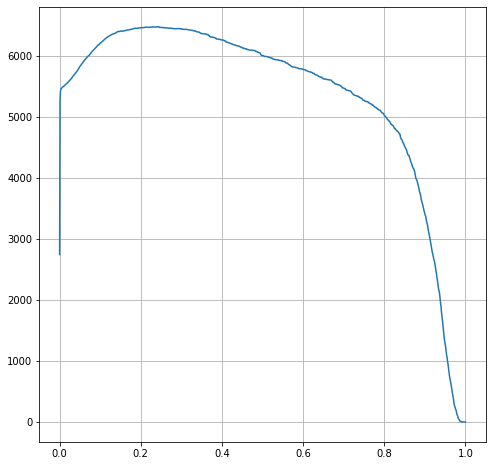

In [48]:
fig, ax = plt.subplots(figsize=(8, 8))

_ = ax.plot(thresholds, scores[:, -1])
_ = ax.grid()

In [49]:
thrsh_best = thresholds[np.argmax(scores[:, -1])]
metrics_best = eval_metrics(
    submission['sale_flg'], submission['scores'],
    submission['sale_amount'], submission['contacts'],
    thrsh_best,
)

print("ROC AUC:   {:.6f}\n"
      "Accuarcy:  {:.6f}\n"
      "Precision: {:.6f}\n"
      "Recall:    {:.6f}\n"
      "F1-score:  {:.6f}\n"
      "ANIC:      {:.6f}\n".format(*metrics_best))

ROC AUC:   0.991573
Accuarcy:  0.962363
Precision: 0.837572
Recall:    0.953009
F1-score:  0.891569
ANIC:      6478.045508

